In [1]:
pip install tensorflow

     |████████████████████████████████| 394.8 MB 30 kB/s  eta 0:00:01   |▍                               | 5.1 MB 1.1 MB/s eta 0:05:51     |█▏                              | 13.9 MB 1.5 MB/s eta 0:04:09     |█▍                              | 16.8 MB 2.0 MB/s eta 0:03:09     |█▊                              | 21.7 MB 1.8 MB/s eta 0:03:30     |██▍                             | 29.3 MB 1.4 MB/s eta 0:04:19     |██▍                             | 30.1 MB 1.6 MB/s eta 0:03:53     |███▋                            | 43.9 MB 1.4 MB/s eta 0:04:20     |████                            | 49.3 MB 1.2 MB/s eta 0:04:45     |████▏                           | 50.7 MB 1.1 MB/s eta 0:05:21     |████▎                           | 53.4 MB 1.9 MB/s eta 0:02:56     |████▍                           | 53.9 MB 1.9 MB/s eta 0:02:56     |████▌                           | 55.4 MB 1.5 MB/s eta 0:03:48     |████▌                           | 55.5 MB 1.5 MB/s eta 0:03:48     |████▋                           | 57.4 MB 2.

     |████████████████████████████████| 47 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 585 kB/s eta 0:00:01
     |████████████████████████████████| 77 kB 798 kB/s eta 0:00:01
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl size=81744 sha256=6129ff5921499e66060dc33fc9d9e635611fae8a99ca1148018ec42ed6b0f195
  Stored in directory: /home/jovyan/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=68fc37d6d0a61f26b490ec504727084a96c7b06c7a8684c091108cf85c2d6569
  Stored in directory: /home/jovyan/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built wrapt termcolor
Note: you may need to restart the kernel to use updated packages.


In [12]:
from common.util import preprocess
import numpy as np

def preprocess(text):
    
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

corpus[1:-1]

def create_contexts_target(corpus, window_size=1):
    target=corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs =[]
        for t in range(-window_size, window_size + 1):
            if t==0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus)
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.float32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.float32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(contexts)
print(vocab_size)


[[[1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]]
7


tf.Tensor(2.7250671, shape=(), dtype=float32)
tf.Tensor(0.435905, shape=(), dtype=float32)
tf.Tensor(0.23859274, shape=(), dtype=float32)
tf.Tensor(0.23437917, shape=(), dtype=float32)
tf.Tensor(0.23312497, shape=(), dtype=float32)
tf.Tensor(0.23253532, shape=(), dtype=float32)
tf.Tensor(0.23219663, shape=(), dtype=float32)
tf.Tensor(0.23197843, shape=(), dtype=float32)
tf.Tensor(0.23182695, shape=(), dtype=float32)
tf.Tensor(0.2317159, shape=(), dtype=float32)


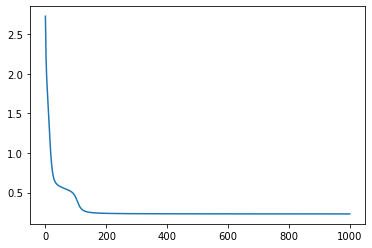

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

class SimpleCBOW:
    def __init__(self, vocab_size=7, hidden_size=2, epochs = 10000, optimizer='sgd'):
        V, H = vocab_size, hidden_size
        weight = tf.constant(0.01,dtype='float64')
        self.epochs = epochs
        
        self.W_in = tf.Variable(tf.random.normal([V, H]), dtype="float32")
        #self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
 
        self.W_out = tf.Variable(tf.random.normal([H, V]), dtype="float32")
        #self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        
        if optimizer=='adam':
            self.optimizer = tf.optimizers.Adam()
        else:
            self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
        
    def train(self, x_train, y_train):
        hist = []
        const = tf.constant(0.5, dtype="float32")
        for _ in range(self.epochs):
            with tf.GradientTape() as g:
                a1 = tf.matmul(x_train[:, 0], self.W_in)
                a2 = tf.matmul(x_train[:, 1], self.W_in)
                a3 = tf.add(a1, a2)
                
                hidden_layer = tf.multiply(const, a3)
                
                output_layer = tf.nn.softmax(tf.matmul(hidden_layer, self.W_out))
                cross_entropy_loss = tf.reduce_mean(-tf.math.reduce_sum(y_train * tf.math.log(output_layer), axis=[1]))
                
                grads = g.gradient(cross_entropy_loss, [self.W_in, self.W_out])
                self.optimizer.apply_gradients(zip(grads,[self.W_in, self.W_out]))
                if(_ % 10==0):
                    hist.append(cross_entropy_loss)
                if(_ % 1000 == 0):
                    print(cross_entropy_loss)
                    
        self._plot_loss(hist)            
        
    def _plot_loss(self, hist):
        plt.plot(hist)
        plt.show()
    
    

w2v = SimpleCBOW(vocab_size=vocab_size, optimizer='sgd', epochs=10000)
w2v.train(contexts, target)
#def plot_distributed(vector):
 #       plt.scatter(vector.T[0],vector.T[1])
   #     plt.show()


[[-3.2400298  -3.2398798 ]
 [-0.05215342  3.3479276 ]
 [ 1.1440284  -1.0004212 ]
 [ 3.0187302   1.2192605 ]
 [ 1.3689622  -3.2706444 ]
 [-3.4332876  -1.5240295 ]
 [-3.2654564   0.88691795]]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


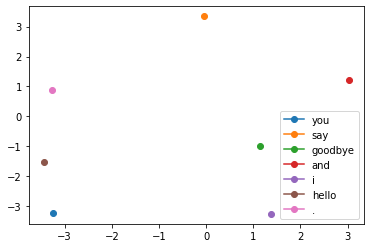

In [14]:
def plot_distributed(vector, id_to_word):
    for i in range(vector.shape[0]):
        plt.plot(vector[i][0], vector[i][1], marker="o", label=id_to_word[i])
        plt.legend()
    plt.show()
    
    
contexts_tf = tf.convert_to_tensor(contexts)
h1 = tf.matmul(contexts_tf, w2v.W_in) 
h2 = tf.matmul(h1, w2v.W_out)
print(w2v.W_in.numpy())
print(id_to_word)
plot_distributed(w2v.W_in.numpy(), id_to_word)